In [1]:

import librosa
import numpy as np
from scipy.spatial.distance import cdist
from math import inf
from typing import List, Tuple
import matplotlib.pyplot as plt

N_MFCC: int = 13
REFERENCE_DURATION: int = 5  # in secs
QUERY_DURATION: int = 2  # in secs
QUERY_OFFSET_DURATION: int = 1  # in secs
hop_samples: int = 512
window_samples: int = 2048
NUM_WINDOWS_RANGE = 2

In [3]:
file: str = r"data/ds1.wav"
y, sr = librosa.load(file, sr = None)
    
reference_samples: int = int(sr * REFERENCE_DURATION)
query_samples: int = int(sr * QUERY_DURATION)
query_offset_samples: int = int(sr * QUERY_OFFSET_DURATION)

print(
    "Ref samples %d q %d q off %d hop %d win %d"
    % (
        reference_samples,
        query_samples,
        query_offset_samples,
        hop_samples,
        window_samples,
    )
)

Ref samples 40000 q 16000 q off 8000 hop 512 win 2048


In [5]:

"""

get_next_distance
    
parameters - 
reference_idx is the current index in the reference
query_idx is the current query index
distances is the distance matrix

functionality:
1. If the alignment process is currently in the middle of the query
and the reference (that is , when there are not any edge conditions) 
the function will use the standard dtw operations of match,delete or insert
2. If the query end is reached, the variable distance will be set to -1
to indicate end of the alignment process
3. If the reference end is reached, the query elements hereafter will
be aligned with the end element of the reference

reference_idx and query_idx will hold the current locations within the
reference and query when the function begins. (for eg: say 4 and 5 are
the reference_idx and query_idx)
when the next best alignment (least distance among the 3) has been
calculated the reference_idx and query_idx will be set accordingly,
meaning they now hold the locations within the reference and query from
where the alignment process needs to be continued. (if the dtw operation
was a match, then the current reference_idx and query_idx would
be 5 and 6 in our example)

similarly for the edge conditions the reference_idx and query_idx
are set accordingly.

returns - 
1. the next distance which is the minimum of the 3 possible distances
2. the next reference index
3. the next query index

"""


def get_next_distance(
    reference_idx: int, query_idx: int, distances: np.ndarray
) -> Tuple[float, int, int]:
    distance: float = 0

    # Reached the end of the query
    if query_idx == distances.shape[1] - 1:
        distance = -1
    else:
        # at the end of the reference, align all the coming queries to this end
        if reference_idx == distances.shape[0] - 1:
            query_idx = query_idx + 1
            assert query_idx < distances.shape[1]
            distance = distances[reference_idx][query_idx]
        else:
            temp_distance: List[float] = []
            min_dist: float = inf
            min_idx: int = -1

            # match
            temp_distance.append(distances[reference_idx + 1][query_idx + 1])
            # insert
            temp_distance.append(distances[reference_idx][query_idx + 1])
            # delete
            temp_distance.append(distances[reference_idx + 1][query_idx])

            for k in range(0, len(temp_distance)):
                if temp_distance[k] < min_dist:
                    min_dist = temp_distance[k]
                    min_idx = k

            if min_idx == 0:
                reference_idx, query_idx = reference_idx + 1, query_idx + 1
            elif min_idx == 1:
                reference_idx, query_idx = reference_idx, query_idx + 1
            else:
                assert min_idx == 2
                reference_idx, query_idx = reference_idx + 1, query_idx

            distance = min_dist

    return distance, reference_idx, query_idx


"""
calculate_min_distance

parameters:
1. reference_idx : the current start of the reference. 
runs from 0 to the number of elements in the reference - 1
2. distances : the distance matrix
3. min_distance : the minimum distance till now. 

functionality:

The reference_idx is aligned with the start of the query.
Then the dtw algorithm is used to find the next alignments.
The current query element could be aligned with the next reference (insert)
The current reference could be aligned with the next query (delete)
The next reference and next query could be aligned with each other (match)

If the current match iteration exceeds the current minimum distance, the
function quits. Since the purpose is to find the match with the minimum
distance, no point in doing further alignment when the distance is not
going to be the best one.

returns:
1. total_distance : the distance for aligning query with the reference
begining at the reference_idx.
2. reference_end_idx : the end of alignment of the query 
within the reference

"""


def calculate_min_distance(
    reference_idx: int, distances: np.ndarray, min_distance: float
) -> Tuple[float, int]:
    total_distance: float = 0
    query_idx: int = 0

    next_distance: float = distances[reference_idx][0]

    while next_distance >= 0:

        total_distance = total_distance + next_distance
        next_distance, reference_idx, query_idx = get_next_distance(
            reference_idx, query_idx, distances
        )

        # no need to traverse any more, this is not the best match
        if total_distance > min_distance:
            break

    return total_distance, reference_idx


"""
least_distance_mfcc

parameters:
1. mfcc_reference : the reference mfcc array
2. mfcc_query : the query mfcc array

functionality:
with every element in the reference as the start the function
calculates the distance of aligning the query with the reference
begining at the current element. for eg. the function first finds the
distance of algning the query with the reference begining at element 0.
if the query is of length 10, it could be alinged with elements 0-8 of
the reference with a total distance of 4.5. Then in the next iteration
with the start of the reference being the first element, the 10 element 
query could be aligned with 1-11 with a total distance of 6.7. Then with
2-10, 3-11 etc. with the respective distances. The best match is the one
with the least distance.

returns:
1. the start of the best match
2. end of the best match
"""


def least_distance_mfcc(
    mfcc_reference: np.ndarray, mfcc_query: np.ndarray
) -> Tuple[int, int]:
    min_distance: float = inf
    start_index: int = 0
    end_index: int = 0

    distances: np.ndarray = cdist(mfcc_reference.T, mfcc_query.T, "euclidean")

    for i in range(0, distances.shape[0]):
        current_distance, end = calculate_min_distance(i, distances, min_distance)
        if current_distance < min_distance:
            min_distance = current_distance
            start_index = i
            end_index = end

    return start_index, end_index



In [6]:
"""
The audio is split into references,of duration REFERENCE_DURATION secs.
In each reference (REFERENCE_DURATION - QUERY_DURATION)
/ QUERY_OFFSET_DURATION queries are formed. 

If the REFERENCE_DURATION is 5 secs and QUERY_DURATION is 2 sec and 
QUERY_OFFSET_DURATION is 1 sec, then queries from 0-2sec, 1-3, 2-4, 3-5
are formed.
"""

# doing len(y) - reference_samples to leave out the last part, which maybe small enough to be lesser than n_fft
for i in range(0, len(y) - reference_samples, reference_samples):
    y_reference = y[i : i + reference_samples]

    mfcc_reference = librosa.feature.mfcc(
        y=y_reference,
        sr=sr,
        n_mfcc=N_MFCC,
        n_fft=window_samples,
        hop_length=hop_samples,
        center=False,
    )

    for j in range(i, i + reference_samples - query_samples, query_offset_samples):
        y_query = y[j : j + query_samples]

        mfcc_query = librosa.feature.mfcc(
            y=y_query,
            sr=sr,
            n_mfcc=N_MFCC,
            n_fft=window_samples,
            hop_length=hop_samples,
            center=False,
        )

        start_index, end_index = least_distance_mfcc(mfcc_reference, mfcc_query)

        expected_start, expected_end = (j - i), (j - i) + query_samples

        """
        there will not be an exact match since the comparison is in the
        time domain. For eg: if the query is from 2-4 secs, then the
        start and the end of the query will not be aligned with the 
        hops within the reference. Hence seeing if the matches are
        within a range of NUM_WINDOWS_RANGE number of windows.
        """

        start_range_begin = expected_start - (window_samples * NUM_WINDOWS_RANGE)
        start_range_end = expected_start + (window_samples * NUM_WINDOWS_RANGE)

        end_range_begin = expected_end - (window_samples * NUM_WINDOWS_RANGE)
        end_range_end = expected_end + (window_samples * NUM_WINDOWS_RANGE)

        if (start_index * hop_samples) not in range(
            start_range_begin, start_range_end
        ) or (end_index * hop_samples) not in range(end_range_begin, end_range_end):
            print(
                "*** i %d j %d exp st %d [diff %d] end %d [diff %d]"
                % (
                    i,
                    j,
                    expected_start,
                    abs(start_index * hop_samples - expected_start),
                    expected_end,
                    abs(end_index * hop_samples - expected_end),
                )
            )

            print(
                "start = %d(sec %f sample %d) end = %d (sec %f sample %d)"
                % (
                    start_index,
                    (start_index * hop_samples) / sr,
                    start_index * hop_samples,
                    end_index,
                    (end_index * hop_samples) / sr,
                    end_index * hop_samples,
                )
            )
            print(
                "Look for %d to %d against %d to %d"
                % (
                    j,
                    j + query_samples,
                    i + (start_index * hop_samples),
                    i + (end_index * hop_samples),
                )
            )

print("DONE :")

*** i 440000 j 456000 exp st 16000 [diff 5504] end 32000 [diff 2304]
start = 42(sec 2.688000 sample 21504) end = 58 (sec 3.712000 sample 29696)
Look for 456000 to 472000 against 461504 to 469696
*** i 920000 j 928000 exp st 8000 [diff 6336] end 24000 [diff 1984]
start = 28(sec 1.792000 sample 14336) end = 43 (sec 2.752000 sample 22016)
Look for 928000 to 944000 against 934336 to 942016
*** i 1840000 j 1840000 exp st 0 [diff 5632] end 16000 [diff 2176]
start = 11(sec 0.704000 sample 5632) end = 27 (sec 1.728000 sample 13824)
Look for 1840000 to 1856000 against 1845632 to 1853824
*** i 7520000 j 7520000 exp st 0 [diff 6656] end 16000 [diff 2176]
start = 13(sec 0.832000 sample 6656) end = 27 (sec 1.728000 sample 13824)
Look for 7520000 to 7536000 against 7526656 to 7533824
*** i 7600000 j 7608000 exp st 8000 [diff 4288] end 24000 [diff 1984]
start = 24(sec 1.536000 sample 12288) end = 43 (sec 2.752000 sample 22016)
Look for 7608000 to 7624000 against 7612288 to 7622016
*** i 7840000 j 785

In [8]:
query_samples

16000

In [80]:
y_reference = y[920000:920000+40000] # 440,000-480,000
y_query = y[928000:928000+16000]     # 456,000-472,000
mfcc_reference = librosa.feature.mfcc(
    y=y_reference,
    sr=sr,
    n_mfcc=N_MFCC,
    n_fft=window_samples,
    hop_length=hop_samples,
    center=False,
)
mfcc_query = librosa.feature.mfcc(
    y=y_query,
    sr=sr,
    n_mfcc=N_MFCC,
    n_fft=window_samples,
    hop_length=hop_samples,
    center=False,
)

D, wp = librosa.sequence.dtw(mfcc_query, mfcc_reference, subseq=True)

[(0.0, 75.0), (0.0, 500.0)]

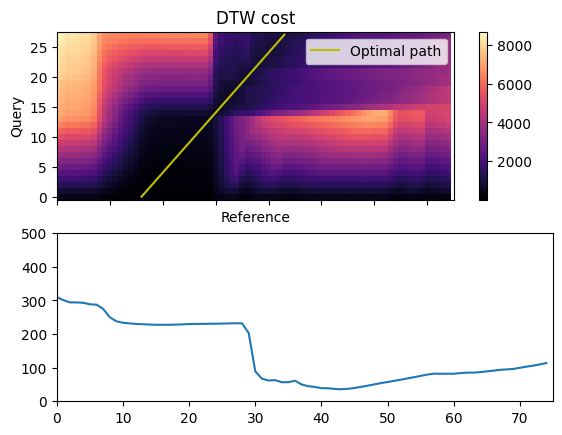

In [81]:
fig, ax = plt.subplots(nrows=2, sharex=True)
img = librosa.display.specshow(D, x_axis='frames', y_axis='frames',
                               ax=ax[0])
ax[0].set(title='DTW cost', xlabel='Reference', ylabel='Query')
ax[0].plot(wp[:, 1], wp[:, 0], label='Optimal path', color='y')
ax[0].legend()
fig.colorbar(img, ax=ax[0])
ax[1].plot(D[-1, :] / wp.shape[0])
ax[1].set(xlim=[0, mfcc_reference.shape[1]], ylim=[0, 500])


In [74]:
from IPython.display import Audio
Audio(data=y_reference, rate=sr)

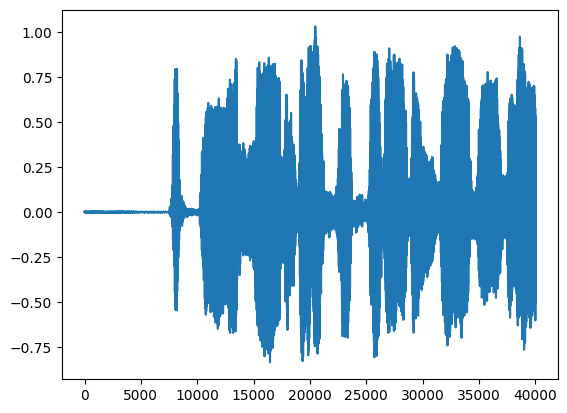

In [75]:
plt.plot(y_reference)

In [76]:
Audio(data=y_query, rate=sr)

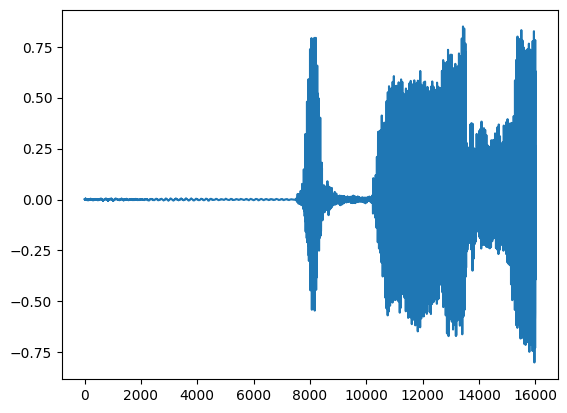

In [77]:
plt.plot(y_query)

In [69]:
end_index = np.argmin(D[-1, :])
print(end_index)

58


In [22]:
58*512

29696

In [38]:
(472000-512)-(440000+58*512)

1792

In [82]:
wp

array([[27, 43],
       [26, 42],
       [25, 41],
       [24, 40],
       [23, 39],
       [22, 38],
       [21, 37],
       [20, 36],
       [19, 35],
       [18, 34],
       [17, 33],
       [16, 32],
       [15, 31],
       [14, 30],
       [13, 29],
       [12, 28],
       [11, 27],
       [10, 26],
       [ 9, 25],
       [ 8, 24],
       [ 7, 23],
       [ 6, 22],
       [ 5, 21],
       [ 4, 20],
       [ 3, 19],
       [ 2, 18],
       [ 1, 17],
       [ 0, 16]])

In [36]:
456000-(440000+32*512)

-384